# Projet Asset Management
ZHANG Mian \
CentraleSupélec

## 0. Imports

In [ ]:
! pip install ffn

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import openpyxl
import os
import ffn
%pylab inline
import scipy.optimize as sco
from scipy.optimize import minimize
import scipy.interpolate as sci
from tqdm import tqdm
import random
from sklearn.isotonic import IsotonicRegression
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data creation

In [ ]:
filename = '/content/drive/MyDrive/ECP_GA_Portfolio.xlsx'

In [ ]:
data = pd.read_excel (filename, sheet_name='New Portfolio',index_col=0, header=0)
equity_list = data.iloc[3]
price_data = data.iloc[6:]

In [ ]:
price_data = price_data.rename(columns = equity_list)
price_data = price_data.dropna(axis=1)
price_data = price_data.iloc[:,:-2]
price_data = price_data.iloc[::-1]
price_data

,AAPL US Equity,MSFT US Equity,AMZN US Equity,GS US Equity,MC FP Equity,DG FP Equity,VIV FP Equity,AIR FP Equity,ACA FP Equity,BNP FP Equity,XAUEUR Curncy,INDMLTO FP Equity,CARMPAT FP Equity
2007-01-03,2.566,21.8298,38.7,163.117,53.2,28.4358,3.8163,21.834,16.5473,46.8154,476.44,299.76,382.458
2007-01-04,2.623,21.7932,38.9,161.598,53.23,28.098,3.8252,21.4325,16.5652,46.7058,475.39,301.07,380.517
2007-01-05,2.604,21.669,38.37,161.76,52.66,27.907,3.7834,21.4994,16.3894,46.0757,467.11,301.87,378.87
2007-01-08,2.617,21.881,37.5,165.564,52.56,27.8483,3.8303,21.1982,16.3376,46.0484,468.38,301.91,378.794
2007-01-09,2.835,21.9029,37.78,165.848,52.13,28.2155,3.9379,21.3739,16.5083,45.9662,472.06,301.7,378.047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,179.29,341.25,3413.22,387.61,730.8,91.4,11.945,113.42,12.55,60.82,1596.89,666.28,712.24
2021-12-29,179.38,341.95,3384.02,386.2,727.9,91.7,11.96,112.12,12.568,60.71,1590.25,661.63,709.78
2021-12-30,178.2,339.32,3372.89,385.52,730,91.98,11.95,112.68,12.604,60.67,1602.44,662.13,712.23
2021-12-31,177.57,336.32,3334.34,382.55,727,92.91,11.89,112.36,12.55,60.77,1608.82,659.82,709.91


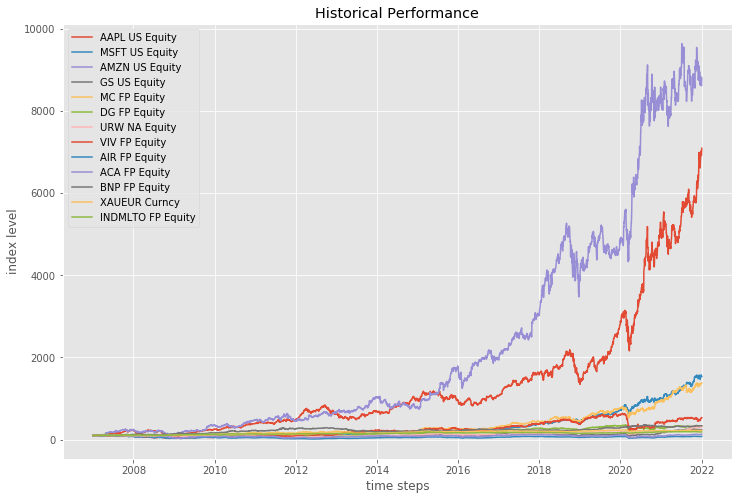

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(price_data.rebase())
plt.xlabel('time steps')
plt.ylabel('index level')
plt.title('Historical Performance')
plt.legend(equity_list, loc='upper left')

In [ ]:
return_data = (price_data / price_data.shift(1)).dropna(axis=0)
return_data = np.log(return_data.astype('float'))
return_data
#return_data.cov()

,AAPL US Equity,MSFT US Equity,AMZN US Equity,GS US Equity,MC FP Equity,DG FP Equity,VIV FP Equity,AIR FP Equity,ACA FP Equity,BNP FP Equity,XAUEUR Curncy,INDMLTO FP Equity,CARMPAT FP Equity
2007-01-04,0.021970,-0.001678,0.005155,-0.009356,0.000564,-0.011951,0.002329,-0.018560,0.001081,-0.002344,-0.002206,0.004361,-0.005088
2007-01-05,-0.007270,-0.005715,-0.013718,0.001002,-0.010766,-0.006821,-0.010988,0.003117,-0.010669,-0.013583,-0.017571,0.002654,-0.004338
2007-01-08,0.004980,0.009736,-0.022935,0.023244,-0.001901,-0.002106,0.012320,-0.014109,-0.003166,-0.000593,0.002715,0.000132,-0.000201
2007-01-09,0.080013,0.001000,0.007439,0.001714,-0.008215,0.013100,0.027704,0.008254,0.010394,-0.001787,0.007826,-0.000696,-0.001974
2007-01-10,0.046520,-0.010063,-0.016816,0.019555,0.009546,-0.008364,-0.002237,-0.019765,-0.001880,-0.014407,0.001016,0.001226,-0.002161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,-0.005784,-0.003510,0.005827,-0.001109,0.006177,0.001314,0.003774,0.009568,0.003672,0.007261,-0.001739,0.000946,0.000941
2021-12-29,0.000502,0.002049,-0.008592,-0.003644,-0.003976,0.003277,0.001255,-0.011528,0.001433,-0.001810,-0.004167,-0.007004,-0.003460
2021-12-30,-0.006600,-0.007721,-0.003294,-0.001762,0.002881,0.003049,-0.000836,0.004982,0.002860,-0.000659,0.007636,0.000755,0.003446
2021-12-31,-0.003542,-0.008881,-0.011495,-0.007734,-0.004118,0.010060,-0.005034,-0.002844,-0.004294,0.001647,0.003974,-0.003495,-0.003263


In [ ]:
return_selection = return_data[return_data.index<datetime.datetime(year = 2008, month = 3, day = 1)]
return_dynamic = return_data[return_data.index>=datetime.datetime(year = 2008, month = 3, day = 1)]
return_static_train = return_dynamic[datetime.datetime(year = 2018, month = 3, day = 1)>return_dynamic.index]
return_static_test = return_data[datetime.datetime(year = 2018, month = 3, day = 1)<=return_data.index]

We split the dataset in four periods:

-a one year selection period, used to select the 5 assets

-the rest of the dataset, used to backtest the dynamic strategies

-a training period, used to chose the weights of the static portfolio

-a testing period, used to assess the performances of the static portfolio

## 2. Stocks selection

In [ ]:
import itertools

indexes = list(itertools.combinations(range(0,return_selection.shape[1]),5))
rets_to_beat = []
inds = []
cov_to_beat = 1
i = 0
n_max = 100
for index in indexes:
    returns = return_selection.iloc[:,list(index)]
    ret = np.mean(returns.to_numpy())
    co = np.cov(returns.to_numpy(),rowvar = False,bias = True)
    co = np.sum(co) - np.sum(np.diag(co))
    if len(rets_to_beat) < n_max:
        rets_to_beat += [ret]
        if co<cov_to_beat:
            cov_to_beat = co
            i=len(index)
        inds += [index]
    else:
        n = np.argmin(rets_to_beat)
        if rets_to_beat[n] < ret:
            rets_to_beat[n] = ret
            inds[n] = index
            if co<cov_to_beat:
                cov_to_beat = co
                i=n

We select the combination of 5 assets that has the lowest average covariance among the 100 combinations that have the highest return on average over the selection period.

In [ ]:
kept_stocks = [equity_list[inds[i][j]] for j in range(5)]
kept_stocks

['AAPL US Equity',
 'MC FP Equity',
 'BNP FP Equity',
 'XAUEUR Curncy',
 'INDMLTO FP Equity']

In [ ]:
return_dynamic = return_dynamic.iloc[:,list(inds[i])]
return_static_train = return_static_train.iloc[:,list(inds[i])]
return_static_test = return_static_test.iloc[:,list(inds[i])]

In [ ]:
return_dynamic.head()

,AAPL US Equity,MC FP Equity,XAUEUR Curncy,INDMLTO FP Equity,CARMPAT FP Equity
2008-03-03 00:00:00,-0.026739,-0.005174,0.008148,0.003008,-0.000556
2008-03-04 00:00:00,0.023599,-0.007375,-0.021009,-0.001818,-0.004196
2008-03-05 00:00:00,-0.001049,0.008671,0.023309,0.000350,0.004935
2008-03-06 00:00:00,-0.029011,-0.013691,-0.018663,-0.007830,0.003970
2008-03-07 00:00:00,0.010744,-0.013881,-0.004299,-0.000846,-0.007799


In [ ]:
cov_static_train = return_static_train.cov()

## 3. Metrics and strategies definition

In [ ]:
def port_ret(weights, rets_means):
    return np.sum(rets_means * weights) * 126

def port_vol(weights, rets_cov):
    return np.sqrt(126* weights.T @ rets_cov @ weights)

def neg_sharpe_ratio(weights, rets_means, rets_cov):  
    return - port_ret(weights, rets_means) / port_vol(weights, rets_cov)  

In [ ]:
def Max_SR_portfolio(rets_means, rets_cov, range_bnds = (0, 1)):
    nb_equity = len(rets_cov)    
    eweights = np.array(nb_equity * [1. / nb_equity,])  
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
    bnds = tuple(range_bnds for x in range(nb_equity))
    objective_SR = lambda x: neg_sharpe_ratio(x, rets_means, rets_cov)
    
    MSR_pf = sco.minimize(objective_SR, eweights, method='SLSQP', bounds=bnds, constraints=cons) 
    
    return MSR_pf, port_vol(MSR_pf['x'], rets_cov), port_ret(MSR_pf['x'], rets_means)

In [ ]:
def MV_portfolio(rets_means, rets_cov, range_bnds = (0, 1)):
    nb_equity = len(rets_cov)    
    eweights = np.array(nb_equity * [1. / nb_equity,])  
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})  
    bnds = tuple(range_bnds for x in range(nb_equity))
    
    MV_pf = sco.minimize(port_vol, eweights,rets_cov,
                    method='SLSQP', bounds=bnds, constraints=cons) 
    
    return MV_pf, port_vol(MV_pf['x'], rets_cov), port_ret(MV_pf['x'], rets_means)

In [ ]:
def sigma_c(Sigma):
    # Step 1 : determining Lambda and V
    Lamb = np.diag(np.linalg.eigh(Sigma)[0])
    V = np.linalg.eigh(Sigma)[1]
    # Step 2 : Computing Lambda clipped
    c = np.sum(Lamb.diagonal() * (Lamb.diagonal() < np.max(Lamb))) / (np.sum(Lamb.diagonal() < np.max(Lamb))) * np.ones(len(Lamb.diagonal()))
    Lamb_c = np.diag(c * (Lamb.diagonal() < np.max(Lamb)) + Lamb.diagonal() * (Lamb.diagonal() == np.max(Lamb)))
    # Step 3 : Computing C_t
    C_t = V @ Lamb_c @ V.transpose()
    # Step 4 : Computing C_c
    C_c = np.zeros(shape = (len(C_t), len(C_t)))
    for i in range(len(C_t)):
        for j in range(len(C_t)):
            C_c[i,j] = C_t[i,j]/(C_t[i,i] * C_t[j,j])

    # Step 5 : Computing clipped covariance matrix
    Sigma_in_c = np.zeros(shape = (len(C_t), len(C_t)))
    for i in range(len(C_t)):
        for j in range(len(C_t)):
            Sigma_in_c[i,j] = C_c[i,j] * Sigma[i,i] * Sigma[j,j]
    return Sigma_in_c

We define 2 main strategies: max sharpe ratio and min variance. We use them with two estimators of the covariance matrix: the historic estimator and the capped estimator, obtained by setting all the eigenvalues of the historic covariance matrix to 0 except for the biggest one.

## 4. Static portfolio

In [ ]:
weights = np.zeros(5)
gain_MV = []
gain_SR = []
gain_MV_clipped = []
gain_SR_clipped = []
gain_index = []

return_in = return_static_train
return_in_mean = return_in.mean()
return_in_cov = np.cov(return_in, rowvar = False, bias = True)
return_in_cov_clipped = sigma_c(return_in_cov)

return_out = return_static_test
return_out_mean = return_out.mean()
return_out_cov = np.cov(return_out, rowvar = False, bias = True)

nb_equity = len(return_in.T)
weight_SR = Max_SR_portfolio(return_in_mean, return_in_cov, range_bnds = (0, 1))[0]['x']
weight_MV = MV_portfolio(return_in_mean, return_in_cov, range_bnds = (0, 1))[0]['x']
weight_SR_clipped = Max_SR_portfolio(return_in_mean, return_in_cov_clipped, range_bnds = (0, 1))[0]['x']
weight_MV_clipped = MV_portfolio(return_in_mean, return_in_cov_clipped, range_bnds = (0, 1))[0]['x']
eq_weights = np.ones(5)/5

return_port_SR = port_ret(weight_SR, return_out_mean)
return_port_MV = port_ret(weight_MV, return_out_mean)
return_port_SR_clipped = port_ret(weight_SR_clipped, return_out_mean)
return_port_MV_clipped = port_ret(weight_MV_clipped, return_out_mean)
return_index = port_ret(eq_weights, return_out_mean)

vol_port_SR = port_vol(weight_SR, return_out_cov)
vol_port_MV = port_vol(weight_MV, return_out_cov)
vol_port_SR_clipped = port_vol(weight_SR_clipped, return_out_cov)
vol_port_MV_clipped = port_vol(weight_MV_clipped, return_out_cov)
vol_index = port_vol(eq_weights, return_out_cov)

sharpe_SR = return_port_SR/vol_port_SR
sharpe_MV = return_port_MV/vol_port_MV
sharpe_SR_clipped = return_port_SR_clipped/vol_port_SR_clipped
sharpe_MV_clipped = return_port_MV_clipped/vol_port_MV_clipped
sharpe_index = return_index/vol_index

In [ ]:
print(sharpe_SR,sharpe_MV,sharpe_SR_clipped,sharpe_MV_clipped,sharpe_index)

0.8898439097081147 0.5831137350881884 0.46301969450953157 0.3389384786036445 0.9526271536471176


The max sharpe ratio with historic covariance matrix performs best among our strategies. However, they are all beaten by an equally weighted portfolio in our testing window. It should be noted that the testing window 2018-2022 is affected by the covid crisis, which may explains the relatively poor performances.

## 5. Dynamic portfolio

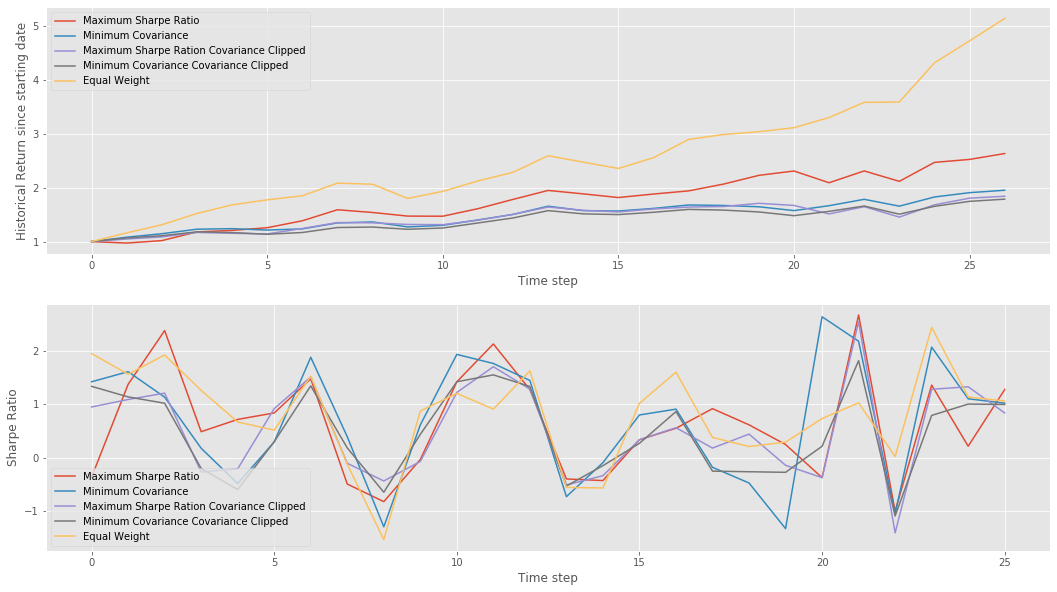

In [ ]:
weights = np.zeros(5)
weight_index = np.array([0.2,0.2,0.2,0.2,0.2])
gain_MV = [0]
gain_SR = [0]
gain_MV_clipped = [0]
gain_SR_clipped = [0]
gain_index = [0]
sharpe_ratio = [0]

SR_SR = []
SR_MV = []
SR_SR_c = []
SR_MV_c = []
SR_index = []

return_port_SR = 0
return_port_MV = 0
return_port_SR_clipped = 0
return_port_MV_clipped = 0
return_index = 0

p_SR = 1
p_MV = 1
p_SR_clipped = 1
p_MV_clipped = 1
p_index = 1

P_MV = [1]
P_SR = [1]
P_MV_c = [1]
P_SR_c = [1]
P_index = [1]

for days in range(252, len(return_dynamic)-126, 126):
    return_in = return_dynamic.iloc[days-252:days, ]
    return_in_mean = return_in.mean()
    return_in_cov = np.cov(return_in, rowvar = False, bias = True)
    return_in_cov_clipped = sigma_c(return_in_cov)

    return_out = return_dynamic.iloc[days:days+126, ]
    return_out_mean = return_out.mean()
    return_out_cov = np.cov(return_out, rowvar = False, bias = True)

    nb_equity = len(return_in.T)
    weight_SR = Max_SR_portfolio(return_in_mean, return_in_cov, range_bnds = (0, 1))[0]['x']
    weight_MV = MV_portfolio(return_in_mean, return_in_cov, range_bnds = (0, 1))[0]['x']
    weight_SR_clipped = Max_SR_portfolio(return_in_mean, return_in_cov_clipped, range_bnds = (0, 1))[0]['x']
    weight_MV_clipped = MV_portfolio(return_in_mean, return_in_cov_clipped, range_bnds = (0, 1))[0]['x']

    return_port_SR += port_ret(weight_SR, return_out_mean)
    return_port_MV += port_ret(weight_MV, return_out_mean)
    return_port_SR_clipped += port_ret(weight_SR_clipped, return_out_mean)
    return_port_MV_clipped += port_ret(weight_MV_clipped, return_out_mean)
    return_index += return_out_mean.mean()*126
    
    p_SR *= 1+port_ret(weight_SR, return_out_mean)
    p_MV *= 1+port_ret(weight_MV, return_out_mean)
    p_SR_clipped *= 1+port_ret(weight_SR_clipped, return_out_mean)
    p_MV_clipped *= 1+port_ret(weight_MV_clipped, return_out_mean)
    p_index *= 1+return_out_mean.mean()*126

    vol_port_SR = port_vol(weight_SR, return_out_cov)
    vol_port_MV = port_vol(weight_MV, return_out_cov)
    vol_port_SR_clipped = port_vol(weight_SR_clipped, return_out_cov)
    vol_port_MV_clipped = port_vol(weight_MV_clipped, return_out_cov)
    vol_port_index = port_vol(weight_index, return_out_cov)

    SR_SR.append(((return_port_SR-gain_SR[-1])/vol_port_SR))
    SR_MV.append(((return_port_MV-gain_MV[-1])/vol_port_MV))
    SR_SR_c.append(((return_port_SR_clipped-gain_SR_clipped[-1])/vol_port_SR_clipped))
    SR_MV_c.append(((return_port_MV_clipped-gain_MV_clipped[-1])/vol_port_SR_clipped))
    SR_index.append(((return_index-gain_index[-1])/vol_index))
                                       
    gain_SR.append(return_port_SR)
    gain_MV.append(return_port_MV)
    gain_SR_clipped.append(return_port_SR_clipped)
    gain_MV_clipped.append(return_port_MV_clipped)
    gain_index.append(return_index)
    
    P_SR.append(p_SR)
    P_MV.append(p_MV)
    P_SR_c.append(p_SR_clipped)
    P_MV_c.append(p_MV_clipped)
    P_index.append(p_index)

fig = plt.figure(figsize = (18,10))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(P_SR, label='Maximum Sharpe Ratio')
ax1.plot(P_MV, label='Minimum Covariance')
ax1.plot(P_SR_c, label='Maximum Sharpe Ration Covariance Clipped')
ax1.plot(P_MV_c, label='Minimum Covariance Covariance Clipped')
ax1.plot(P_index, label='Equal Weight')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Historical Return since starting date')
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
ax2.plot(SR_SR, label='Maximum Sharpe Ratio')
ax2.plot(SR_MV, label='Minimum Covariance')
ax2.plot(SR_SR_c, label='Maximum Sharpe Ration Covariance Clipped')
ax2.plot(SR_MV_c, label='Minimum Covariance Covariance Clipped')
ax2.plot(SR_index, label='Equal Weight')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Sharpe Ratio')
ax2.legend()

In [ ]:
print(np.mean(SR_SR),np.mean(SR_MV),np.mean(SR_SR_c),np.mean(SR_MV_c),np.mean(SR_index))

0.6278244513314 0.6809187021467289 0.5193745085032088 0.4608307131658638 0.8113408395999259


The equally weighted portfolio and the maximum Sharpe ratio with historic covariance matrix are the best performers in terms of returns. However, the minimum variance portfolio is better than the maximum sharpe ratio in terms of sharpe ratio over the period.

## 5. Introducing leverage to the dynamic portfolio

In [ ]:
def CPPI(equity_price, floor, multiplier):
  equity_value = np.ones(len(equity_price))
  equity_amount = np.ones(len(equity_price))
  total_value = np.ones(len(equity_price)) 
  bond_value = np.ones(len(equity_price))

  equity_amount[0] = (equity_price[0] - floor) * multiplier
  equity_value[0] = equity_price[0] * equity_amount[0]
  bond_value[0] = total_value[0] - equity_amount[0] * equity_value[0]

  for i in range(0, len(equity_price) - 1):
    equity_value[i+1] = multiplier * equity_amount[i] * equity_price[i+1] + bond_value[i] - floor
    equity_amount[i+1] = equity_value[i+1] / equity_price[i+1]
    bond_value[i+1] = equity_amount[i]*equity_price[i+1] + bond_value[i] - equity_value[i+1]
    total_value[i+1] = equity_value[i+1] + bond_value[i+1]
  return total_value

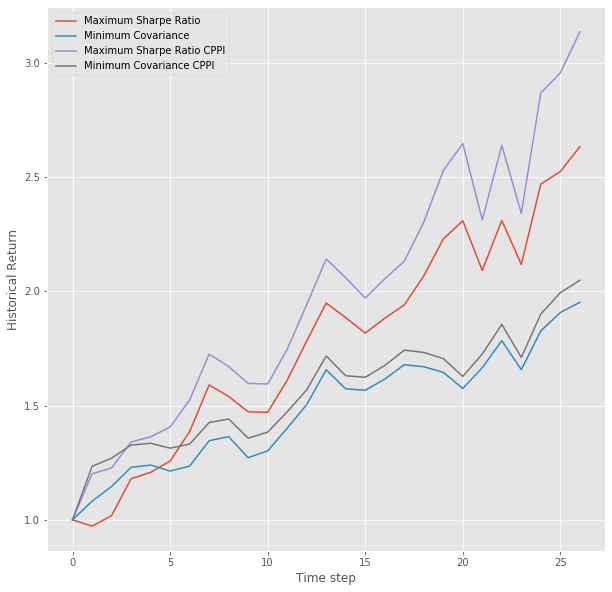

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
ax.plot(P_SR, label='Maximum Sharpe Ratio')
ax.plot(P_MV, label='Minimum Covariance')
ax.plot(CPPI(P_SR, 0.8, 1.5), label='Maximum Sharpe Ratio CPPI')
ax.plot(CPPI(P_MV, 0.8, 1.5) , label='Minimum Covariance CPPI')
#ax.plot(gain_SR_clipped, label='Maximum Sharpe Ration Covariance Clipped')
#ax.plot(gain_MV_clipped, label='Minimum Covariance Covariance Clipped')
#ax.plot(gain_index, label='Equal Weight')
ax.set_xlabel('Time step')
ax.set_ylabel('Historical Return')
ax.legend()